# **LSTM Fused Decision - Feature Set 3**

We will create a Fused Decision machine learning architecture to try and best process our data.

We will run the LSTM fused decision as we have done for the previous feature sets.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import itertools
import pickle
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [ ]:
import optuna

### **Functions to prepare the dataset**

# **Load the data**

In [ ]:
# Load the sequences and labels
low_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/low_frequency_train_sequences_v1.npy'
medium_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/medium_frequency_train_sequences_v1.npy'
high_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/high_frequency_train_sequences_v1.npy'
labels_train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/train_labels_v1.npy'

low_freq_train_sequences = np.load(low_train_seq_path, allow_pickle=True).astype(np.float32)
medium_freq_train_sequences = np.load(medium_train_seq_path, allow_pickle=True).astype(np.float32)
high_freq_train_sequences = np.load(high_train_seq_path, allow_pickle=True).astype(np.float32)
labels_train = np.load(labels_train_path, allow_pickle=True).astype(np.float32)

print("Low frequency sequences shape:", low_freq_train_sequences.shape)
print("Medium frequency sequences shape:", medium_freq_train_sequences.shape)
print("High frequency sequences shape:", high_freq_train_sequences.shape)
print("Labels shape:", labels_train.shape)

Low frequency sequences shape: (3760, 4, 18)
Medium frequency sequences shape: (3760, 7, 10)
High frequency sequences shape: (3760, 13, 6)
Labels shape: (3760,)


# **NOTE**

The extracted data from feature set 3 once processed (data extracted, threshold for sampling frequency set) only has one additional feature compared to the second feature set.

Any model training on one extra feature would be meaningless and a waste of computational resources.

As such, we will amend the sampling threshold for feature set 3 to be in line with Zeng et al (0.1 in 4 hours) to be 0.15 in 4 hours instead. This allows us to have more features to develop a model on. Although it means a larger % of data would need to be synthesised, this will be balanced slightly as all the additional features would feature in the lowest frequency group and hence have a lower resampling rate applied when interpolated.

# **Experiment 1**

We can now commence hyperparameter tuning using Bayesian Optimisation.

In [ ]:
class MultiInputTimeSeriesDataset(Dataset):
    """
    A custom PyTorch Dataset class for time series data with multiple input sequences.

    Args:
        low_sequences (numpy.ndarray): Low-frequency sequences.
        medium_sequences (numpy.ndarray): Medium-frequency sequences.
        high_sequences (numpy.ndarray): High-frequency sequences.
        labels (numpy.ndarray): Corresponding labels for the sequences.

    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Returns a dictionary containing the sequences and label for the given index.
    """
    def __init__(self, low_sequences, medium_sequences, high_sequences, labels):
        self.low_sequences = low_sequences
        self.medium_sequences = medium_sequences
        self.high_sequences = high_sequences
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'low_freq_sequence': torch.tensor(self.low_sequences[idx], dtype=torch.float32),
            'medium_freq_sequence': torch.tensor(self.medium_sequences[idx], dtype=torch.float32),
            'high_freq_sequence': torch.tensor(self.high_sequences[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

In [ ]:
def create_multi_input_data_loaders(low_freq_train_sequences,
                                    medium_freq_train_sequences,
                                    high_freq_train_sequences,
                                    train_labels,
                                    low_freq_val_sequences,
                                    medium_freq_val_sequences,
                                    high_freq_val_sequences,
                                    val_labels,
                                    low_freq_test_sequences,
                                    medium_freq_test_sequences,
                                    high_freq_test_sequences,
                                    test_labels,
                                    batch_size):
    """
    Creates PyTorch DataLoader objects for training, validation, and test sets with multiple inputs.

    Args:
        low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences: Training sequences.
        train_labels: Training labels for all sequences.
        low_freq_val_sequences, medium_freq_val_sequences, high_freq_val_sequences: Validation sequences.
        val_labels: Validation labels for all sequences.
        low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences: Test sequences.
        test_labels: Test labels for all sequences.
        batch_size: Batch size for the DataLoaders.

    Returns:
        tuple: A tuple containing the train, validation, and test DataLoaders.
    """
    train_dataset = MultiInputTimeSeriesDataset(low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_labels)
    val_dataset = MultiInputTimeSeriesDataset(low_freq_val_sequences, medium_freq_val_sequences, high_freq_val_sequences, val_labels)
    test_dataset = MultiInputTimeSeriesDataset(low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

**SMOTE and RandomUnderSampler do not seem to be able to handle NaNs we will handle under and oversampling manually.**

In [ ]:
import numpy as np
from sklearn.utils import resample

def undersample_data(low_sequences, labels, medium_sequences, high_sequences):
    """
    Undersamples the data by randomly reducing the majority class samples.

    Args:
        low_sequences (np.ndarray): Low frequency sequences.
        labels (np.ndarray): Corresponding labels for sequences.
        medium_sequences (np.ndarray): Medium frequency sequences.
        high_sequences (np.ndarray): High frequency sequences.

    Returns:
        tuple: Undersampled sequences and labels for low, medium, and high frequency data.
    """
    # Identify the minority and majority classes
    minority_class = min(set(labels), key=list(labels).count)
    majority_class = max(set(labels), key=list(labels).count)

    # Split the data into minority and majority classes
    minority_indices = np.where(labels == minority_class)[0]
    majority_indices = np.where(labels == majority_class)[0]

    # Randomly undersample the majority class
    undersampled_majority_indices = resample(majority_indices, replace=False, n_samples=len(minority_indices), random_state=42)

    # Combine minority and undersampled majority indices
    undersampled_indices = np.concatenate([minority_indices, undersampled_majority_indices])

    # Get the undersampled sequences and labels
    low_sequences_resampled = low_sequences[undersampled_indices]
    labels_resampled = labels[undersampled_indices]
    medium_sequences_resampled = medium_sequences[undersampled_indices]
    high_sequences_resampled = high_sequences[undersampled_indices]

    return low_sequences_resampled, labels_resampled, medium_sequences_resampled, high_sequences_resampled

def oversample_data(low_sequences, labels, medium_sequences, high_sequences):
    """
    Oversamples the data by duplicating the minority class samples.

    Args:
        low_sequences (np.ndarray): Low frequency sequences.
        labels (np.ndarray): Corresponding labels for sequences.
        medium_sequences (np.ndarray): Medium frequency sequences.
        high_sequences (np.ndarray): High frequency sequences.

    Returns:
        tuple: Oversampled sequences and labels for low, medium, and high frequency data.
    """
    # Identify the minority and majority classes
    minority_class = min(set(labels), key=list(labels).count)
    majority_class = max(set(labels), key=list(labels).count)

    # Split the data into minority and majority classes
    minority_indices = np.where(labels == minority_class)[0]
    majority_indices = np.where(labels == majority_class)[0]

    # Randomly oversample the minority class
    oversampled_minority_indices = resample(minority_indices, replace=True, n_samples=len(majority_indices), random_state=42)

    # Combine majority and oversampled minority indices
    oversampled_indices = np.concatenate([majority_indices, oversampled_minority_indices])

    # Get the oversampled sequences and labels
    low_sequences_resampled = low_sequences[oversampled_indices]
    labels_resampled = labels[oversampled_indices]
    medium_sequences_resampled = medium_sequences[oversampled_indices]
    high_sequences_resampled = high_sequences[oversampled_indices]

    return low_sequences_resampled, labels_resampled, medium_sequences_resampled, high_sequences_resampled

In [ ]:
class FusedLSTMModel(nn.Module):
    """
    A fused LSTM model for sequence classification and handles masking.

    """
    def __init__(self, low_input_dim, medium_input_dim, high_input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
      super(FusedLSTMModel, self).__init__()
      self.hidden_dim = hidden_dim
      self.layer_dim = layer_dim

      if layer_dim == 1:
        dropout_prob = 0.0

      # Define the LSTM layers
      self.low_lstm = nn.LSTM(low_input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
      self.medium_lstm = nn.LSTM(medium_input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
      self.high_lstm = nn.LSTM(high_input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

      # Define the fully connected layer to fuse outputs
      self.fc = nn.Linear(hidden_dim * 3, output_dim)

      # Define sigmoid for binary classification
      self.sigmoid = nn.Sigmoid()

    def forward(self, low_x, medium_x, high_x):
      # Create masks and handle NaNs
      low_mask = ~low_x.isnan()
      medium_mask = ~medium_x.isnan()
      high_mask = ~high_x.isnan()

      # Set NaNs to zeroes to be passed through model
      low_x = torch.where(low_mask, low_x, torch.zeros_like(low_x))
      medium_x = torch.where(medium_mask, medium_x, torch.zeros_like(medium_x))
      high_x = torch.where(high_mask, high_x, torch.zeros_like(high_x))

      # Initial hidden and cell states
      h0_low = torch.zeros(self.layer_dim, low_x.size(0), self.hidden_dim).to(low_x.device)
      c0_low = torch.zeros(self.layer_dim, low_x.size(0), self.hidden_dim).to(low_x.device)

      h0_medium = torch.zeros(self.layer_dim, medium_x.size(0), self.hidden_dim).to(medium_x.device)
      c0_medium = torch.zeros(self.layer_dim, medium_x.size(0), self.hidden_dim).to(medium_x.device)

      h0_high = torch.zeros(self.layer_dim, high_x.size(0), self.hidden_dim).to(high_x.device)
      c0_high = torch.zeros(self.layer_dim, high_x.size(0), self.hidden_dim).to(high_x.device)

      # Forward pass through LSTM layers
      low_out, _ = self.low_lstm(low_x, (h0_low, c0_low))
      medium_out, _ = self.medium_lstm(medium_x, (h0_medium, c0_medium))
      high_out, _ = self.high_lstm(high_x, (h0_high, c0_high))

      # Ensure masks are the same shape as the LSTM outputs
      low_mask = low_mask[:, :, 0].unsqueeze(-1).expand(-1, -1, low_out.shape[-1])
      medium_mask = medium_mask[:, :, 0].unsqueeze(-1).expand(-1, -1, medium_out.shape[-1])
      high_mask = high_mask[:, :, 0].unsqueeze(-1).expand(-1, -1, high_out.shape[-1])

      # Apply masks to the LSTM outputs by zeroing out invalid positions
      low_out = low_out * low_mask.float()
      medium_out = medium_out * medium_mask.float()
      high_out = high_out * high_mask.float()

      # Get the last valid output for each sequence
      def get_last_valid_output(output, mask):
        last_valid_index = mask.sum(dim=1) - 1
        last_valid_index = torch.clamp(last_valid_index, min=0)  # Ensure no negative indices
        last_valid_index = last_valid_index.unsqueeze(1).unsqueeze(2).expand(-1, 1, output.size(-1))
        return output.gather(1, last_valid_index).squeeze(1)

      low_out_last = get_last_valid_output(low_out, low_mask[:, :, 0])
      medium_out_last = get_last_valid_output(medium_out, medium_mask[:, :, 0])
      high_out_last = get_last_valid_output(high_out, high_mask[:, :, 0])

      # Concatenate the outputs
      out = torch.cat((low_out_last, medium_out_last, high_out_last), dim=1)

      # Apply the fully connected layer to fuse outputs
      out = self.fc(out)

      # Apply sigmoid for binary classification
      out = self.sigmoid(out)

      return out

In [ ]:
def train_fused_model_with_early_stopping_logging(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience, output_path):
    """
    Train the fused LSTM model with early stopping and logging.

    Parameters:
    model (nn.Module): The fused LSTM model to be trained.
    train_loader (DataLoader): DataLoader for the training data.
    val_loader (DataLoader): DataLoader for the validation data.
    criterion (nn.Module): Loss function.
    optimizer (torch.optim.Optimizer): Optimizer.
    num_epochs (int): Number of epochs to train the model.
    device (torch.device): Device to run the model on (CPU or GPU).
    patience (int): Number of epochs to wait for improvement before stopping early.
    output_path (str): Path to save the best model checkpoint.

    Returns:
    model (nn.Module): The trained LSTM model.
    train_losses (list): List of training losses per epoch.
    val_losses (list): List of validation losses per epoch.
    val_aucs (list): List of validation AUC scores per epoch.
    """
    model.to(device)
    best_model_wts = model.state_dict()
    best_auc = 0.0

    early_stopping = EarlyStopping(output_path, patience=patience, min_delta=0)

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in train_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * low_freq_sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_running_loss = 0.0
        val_outputs = []
        val_labels = []

        with torch.no_grad():
            for data in val_loader:
                low_freq_sequences = data['low_freq_sequence'].to(device)
                medium_freq_sequences = data['medium_freq_sequence'].to(device)
                high_freq_sequences = data['high_freq_sequence'].to(device)
                labels = data['label'].to(device).view(-1, 1)

                outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)

                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * low_freq_sequences.size(0)

                val_outputs.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        val_auc = roc_auc_score(val_labels, val_outputs)
        val_aucs.append(val_auc)

        early_stopping(val_auc, model)

        if val_auc > best_auc:
            best_auc = val_auc
            best_model_wts = model.state_dict()

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_aucs

In [ ]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.

    Args:
        output_path (str): Path to save the best model checkpoint.
        patience (int, optional): How long to wait after last time validation loss improved. Defaults to 5.
        min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement. Defaults to 0.
    """
    def __init__(self, output_path, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.output_path = output_path

    def __call__(self, val_auc, model):
        """
        Checks the validation AUC and decides whether to stop training.

        Args:
            val_auc (float): Validation AUC score.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_score is None:
            self.best_score = val_auc
            self.save_checkpoint(model)
        elif val_auc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_auc
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """
        Saves the model checkpoint.

        Args:
            model (torch.nn.Module): The model to save.
        """
        torch.save(model.state_dict(), self.output_path)

In [ ]:
def shuffle_data(sequences, labels):
    assert len(sequences) == len(labels)
    p = np.random.permutation(len(sequences))
    return sequences[p], labels[p]

def split_data_into_folds(sequences, labels, num_folds):
    fold_size = len(sequences) // num_folds
    sequences_folds = []
    labels_folds = []
    for i in range(num_folds):
        start_idx = i * fold_size
        if i == num_folds - 1:  # Make sure the last fold includes any remaining data points
            end_idx = len(sequences)
        else:
            end_idx = start_idx + fold_size
        sequences_folds.append(sequences[start_idx:end_idx])
        labels_folds.append(labels[start_idx:end_idx])
    return sequences_folds, labels_folds

In [ ]:
def reset_model(model):
    """
    Reset the parameters of the model to their initial values.

    Parameters:
    model (nn.Module): The model whose parameters need to be reset.
    """
    def reset_parameters(layer):
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    # Iterate over each module in the model and reset parameters if possible
    for layer in model.children():
        if isinstance(layer, nn.Module):
            reset_parameters(layer)
            # Recursively reset parameters for any sub-modules
            for sub_layer in layer.children():
                reset_parameters(sub_layer)

In [ ]:
def manual_cross_validation(low_sequences, medium_sequences, high_sequences, labels, hyperparameters, num_folds=5, patience=5, output_path=None):
    """
    Perform manual cross-validation for the fused LSTM model.

    Parameters:
    low_sequences (np.array): Low frequency sequences.
    medium_sequences (np.array): Medium frequency sequences.
    high_sequences (np.array): High frequency sequences.
    labels (np.array): Labels for sequences.
    hyperparameters (list): List of hyperparameter dictionaries to evaluate.
    num_folds (int): Number of folds for cross-validation. Default is 5.
    patience (int): Number of epochs to wait for improvement before stopping early. Default is 5.
    output_path (str): Path to save the best model checkpoint.

    Returns:
    tuple: Best model, best hyperparameters, best AUC score.
    """
    def shuffle_data(sequences, labels):
        assert len(sequences) == len(labels)
        p = np.random.permutation(len(sequences))
        return sequences[p], labels[p]

    def split_data_into_folds(sequences, labels, num_folds):
        fold_size = len(sequences) // num_folds
        sequences_folds = []
        labels_folds = []
        for i in range(num_folds):
            start_idx = i * fold_size
            if i == num_folds - 1:  # Make sure the last fold includes any remaining data points
                end_idx = len(sequences)
            else:
                end_idx = start_idx + fold_size
            sequences_folds.append(sequences[start_idx:end_idx])
            labels_folds.append(labels[start_idx:end_idx])
        return sequences_folds, labels_folds

    # Shuffle and split the data into folds
    low_sequences, labels = shuffle_data(low_sequences, labels)
    medium_sequences, _ = shuffle_data(medium_sequences, labels)
    high_sequences, _ = shuffle_data(high_sequences, labels)

    low_sequences_folds, labels_folds = split_data_into_folds(low_sequences, labels, num_folds)
    medium_sequences_folds, _ = split_data_into_folds(medium_sequences, labels, num_folds)
    high_sequences_folds, _ = split_data_into_folds(high_sequences, labels, num_folds)

    best_auc = 0.0
    best_model = None
    best_hyperparams = None

    best_train_losses = None
    best_val_losses = None
    best_val_aucs = None

    for i in range(num_folds):
        # Separate into train and validation sets
        val_low_sequences = low_sequences_folds[i]
        val_labels = labels_folds[i]
        train_low_sequences = np.concatenate([low_sequences_folds[j] for j in range(num_folds) if j != i])
        train_labels = np.concatenate([labels_folds[j] for j in range(num_folds) if j != i])

        val_medium_sequences = medium_sequences_folds[i]
        train_medium_sequences = np.concatenate([medium_sequences_folds[j] for j in range(num_folds) if j != i])

        val_high_sequences = high_sequences_folds[i]
        train_high_sequences = np.concatenate([high_sequences_folds[j] for j in range(num_folds) if j != i])

        for params in hyperparameters:
            # Handle sampling methods
            if params['sampling_method'] == 'undersample':
                train_low_sequences_resampled, train_labels_resampled, train_medium_sequences_resampled, train_high_sequences_resampled = undersample_data(
                    train_low_sequences, train_labels, train_medium_sequences, train_high_sequences
                )
            elif params['sampling_method'] == 'oversample':
                train_low_sequences_resampled, train_labels_resampled, train_medium_sequences_resampled, train_high_sequences_resampled = oversample_data(
                    train_low_sequences, train_labels, train_medium_sequences, train_high_sequences
                )
            else:
                train_low_sequences_resampled, train_labels_resampled = train_low_sequences, train_labels
                train_medium_sequences_resampled, train_high_sequences_resampled = train_medium_sequences, train_high_sequences

            # Create data loaders for each subset using the provided function
            train_loader, val_loader, _ = create_multi_input_data_loaders(
                train_low_sequences_resampled,
                train_medium_sequences_resampled,
                train_high_sequences_resampled,
                train_labels_resampled,
                val_low_sequences,
                val_medium_sequences,
                val_high_sequences,
                val_labels,
                val_low_sequences, # Placeholder
                val_medium_sequences, # Placeholder
                val_high_sequences, # Placeholder
                val_labels, # Placeholder
                batch_size=params['batch_size']
            )

            # Determine the input_dim for each subset
            low_input_dim = train_low_sequences.shape[2]
            medium_input_dim = train_medium_sequences.shape[2]
            high_input_dim = train_high_sequences.shape[2]

            # Initialize the model
            model = FusedLSTMModel(
                low_input_dim=low_input_dim,
                medium_input_dim=medium_input_dim,
                high_input_dim=high_input_dim,
                hidden_dim=params['hidden_dim'],
                layer_dim=params['layer_dim'],
                output_dim=1,
                dropout_prob=params['dropout_prob']
            ).to(device)

            # Reset the model parameters
            reset_model(model)

            # Define the loss function
            criterion = nn.BCELoss()

            # Apply weighted loss function if indicated and where sampling is not over or undersampling
            if params['loss'] == 'weighted' and params['sampling_method'] == 'normal':
                pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Create weighted loss

            # Define the optimizer with learning rate and L2 weight decay
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

            # Train the model with early stopping and logging
            model, train_losses, val_losses, val_aucs = train_fused_model_with_early_stopping_logging(
                model, train_loader, val_loader, criterion, optimizer,
                params['num_epochs'], device, patience, output_path
            )

            # Evaluate the model
            val_outputs = []
            val_labels_list = []
            model.eval()
            with torch.no_grad():
                for data in val_loader:
                    low_freq_sequences = data['low_freq_sequence'].to(device)
                    medium_freq_sequences = data['medium_freq_sequence'].to(device)
                    high_freq_sequences = data['high_freq_sequence'].to(device)
                    labels_batch = data['label'].to(device).view(-1, 1)
                    outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)

                    val_outputs.extend(outputs.cpu().numpy().flatten())
                    val_labels_list.extend(labels_batch.cpu().numpy().flatten())

            val_auc = roc_auc_score(val_labels_list, val_outputs)
            if val_auc > best_auc:
                best_auc = val_auc
                best_model = model
                best_hyperparams = params
                best_train_losses = train_losses
                best_val_losses = val_losses
                best_val_aucs = val_aucs

            print(f"Params: {params}, Val AUC: {val_auc:.4f}")

    # Plot training and validation loss and AUC for the best model
    if best_train_losses and best_val_losses and best_val_aucs:
        epochs = range(1, len(best_train_losses) + 1)
        plt.figure(figsize=(16, 6))

        # Plot training and validation loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, best_train_losses, 'b-', label='Training loss')
        plt.plot(epochs, best_val_losses, 'r-', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot validation AUC
        plt.subplot(1, 2, 2)
        plt.plot(epochs, best_val_aucs, 'g-', label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return best_model, best_hyperparams, best_auc

**Load the data**

**Define parameter grid and objective function**

In [ ]:
param_grid = {
    'hidden_dim': [32, 64, 128, 256, 512],
    'layer_dim': [1, 2, 3, 4], # In line with Zeng et al.
    'dropout_prob': [0.0, 0.25, 0.5, 0.75], # In line with Zeng et al.
    'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
    'batch_size': [16, 32, 64, 128],
    'num_epochs': [10, 20, 30, 40, 50],
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [0.00001, 0.0001, 0.001, 0.01]
}

param_combinations = list(itertools.product(*param_grid.values()))

param_combinations = [
    dict(zip(param_grid.keys(), combination))
    for combination in param_combinations
]

print(f"Number of parameter combinations: {len(param_combinations)}")

Number of parameter combinations: 153600


In [ ]:
def objective_wrapper(low_train_sequences, medium_train_sequences, high_train_sequences, train_labels, hyperparameter_grid):
    """
    Wrapper function for the Optuna objective.

    Parameters:
    low_train_sequences (np.array): Low frequency training sequences.
    medium_train_sequences (np.array): Medium frequency training sequences.
    high_train_sequences (np.array): High frequency training sequences.
    train_labels (np.array): Labels for training sequences.
    hyperparameter_grid (dict): Dictionary containing hyperparameters and their possible values.

    Returns:
    function: Optuna objective function.
    """
    def objective(trial):
        hidden_dim = trial.suggest_categorical('hidden_dim', hyperparameter_grid['hidden_dim'])
        layer_dim = trial.suggest_categorical('layer_dim', hyperparameter_grid['layer_dim'])
        dropout_prob = trial.suggest_categorical('dropout_prob', hyperparameter_grid['dropout_prob'])
        learning_rate = trial.suggest_categorical('learning_rate', hyperparameter_grid['learning_rate'])
        batch_size = trial.suggest_categorical('batch_size', hyperparameter_grid['batch_size'])
        num_epochs = trial.suggest_categorical('num_epochs', hyperparameter_grid['num_epochs'])
        sampling_method = trial.suggest_categorical('sampling_method', hyperparameter_grid['sampling_method'])
        loss = trial.suggest_categorical('loss', hyperparameter_grid['loss'])
        weight_decay = trial.suggest_categorical('weight_decay', hyperparameter_grid['weight_decay'])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
            raise optuna.TrialPruned()

        hyperparameters = {
            'hidden_dim': hidden_dim,
            'layer_dim': layer_dim,
            'dropout_prob': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
            'weight_decay': weight_decay
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc = manual_cross_validation(
            low_train_sequences,
            medium_train_sequences,
            high_train_sequences,
            train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

### **Run Bayesian Optimisation**

In [ ]:
study_exp_1 = optuna.create_study(direction='minimize')
study_exp_1.optimize(objective_wrapper(low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, labels_train, param_grid), n_trials=100)

best_params = study_exp_1.best_params
print("Best hyperparameters:", best_params)

best_score = study_exp_1.best_value
print("Best score:", best_score)

# Save the best hyperparameters
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/01_lstm_fused_decision/dynamic_data/best_models/experiment_1/best_params.json'
with open(params_path, 'w') as f:
    json.dump(best_params, f)

Output hidden; open in https://colab.research.google.com to view.

Best hyperparameters: {'hidden_dim': 32, 'layer_dim': 3, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 16, 'num_epochs': 50, 'sampling_method': 'undersample', 'loss': 'normal', 'weight_decay': 1e-05}

Best score: -0.5620724151284369

In [ ]:
best_params = {'hidden_dim': 32, 'layer_dim': 3, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 16, 'num_epochs': 50, 'sampling_method': 'undersample', 'loss': 'normal', 'weight_decay': 1e-05}

### **Train the final model**

In [ ]:
# Load the test sequences
low_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/low_frequency_test_sequences_v1.npy'
medium_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/medium_frequency_test_sequences_v1.npy'
high_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/high_frequency_test_sequences_v1.npy'

# Load the test labels
test_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/test_labels_v1.npy'

low_freq_test_sequences = np.load(low_test_seq_path, allow_pickle=True).astype(np.float32)
medium_freq_test_sequences = np.load(medium_test_seq_path, allow_pickle=True).astype(np.float32)
high_freq_test_sequences = np.load(high_test_seq_path, allow_pickle=True).astype(np.float32)

labels_test = np.load(test_labels_path, allow_pickle=True).astype(np.float32)

print(f'Low frequency test sequences shape: {low_freq_test_sequences.shape}')
print(f'Medium frequency test sequences shape: {medium_freq_test_sequences.shape}')
print(f'High frequency test sequences shape: {high_freq_test_sequences.shape}')
print(f'Test labels shape: {labels_test.shape}')

Low frequency test sequences shape: (941, 4, 18)
Medium frequency test sequences shape: (941, 7, 10)
High frequency test sequences shape: (941, 13, 6)
Test labels shape: (941,)


In [ ]:
final_model = FusedLSTMModel(
    low_input_dim=low_freq_train_sequences.shape[2],
    medium_input_dim=medium_freq_train_sequences.shape[2],
    high_input_dim=high_freq_train_sequences.shape[2],
    hidden_dim=best_params['hidden_dim'],
    layer_dim=best_params['layer_dim'],
    output_dim=1,
    dropout_prob=best_params['dropout_prob']
).to(device)

final_model

FusedLSTMModel(
  (low_lstm): LSTM(18, 32, num_layers=3, batch_first=True, dropout=0.5)
  (medium_lstm): LSTM(10, 32, num_layers=3, batch_first=True, dropout=0.5)
  (high_lstm): LSTM(6, 32, num_layers=3, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=96, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Handle sampling methods
if best_params['sampling_method'] == 'oversample':
  train_low_sequences_resampled, train_labels_resampled, train_medium_sequences_resampled, train_high_sequences_resampled = oversample_data(
      low_freq_train_sequences, labels_train,
      medium_freq_train_sequences, high_freq_train_sequences)
elif best_params['sampling_method'] == 'undersample':
  train_low_sequences_resampled, train_labels_resampled, train_medium_sequences_resampled, train_high_sequences_resampled = undersample_data(
      low_freq_train_sequences, labels_train,
      medium_freq_train_sequences, high_freq_train_sequences)
else:
  train_low_sequences_resampled, train_labels_resampled = low_freq_train_sequences, labels_train
  train_medium_sequences_resampled, train_high_sequences_resampled = medium_freq_train_sequences, high_freq_train_sequences

# Define the loss function
if best_params['loss'] == 'weighted':
  pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
  criterion = nn.BCELoss()

# Define the optimizer with learning rate and L2 weight decay
optimizer = optim.Adam(
    final_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
final_model = final_model.to(device)

# Create data loaders
train_loader, _ , test_loader = create_multi_input_data_loaders(
    train_low_sequences_resampled,
    train_medium_sequences_resampled,
    train_high_sequences_resampled,
    train_labels_resampled,
    _,
    _,
    _,
    _,
    low_freq_test_sequences,
    medium_freq_test_sequences,
    high_freq_test_sequences,
    labels_test,
    batch_size=best_params['batch_size']
)

**Train the final model**

In [ ]:
# Train the final model on the whole training set
def train_final_model(model, train_loader, criterion, optimizer, num_epochs, device):
    """
    Train the model with the given parameters.

    Parameters:
    model (nn.Module): The neural network model to be trained.
    train_loader (DataLoader): The DataLoader for the training dataset.
    criterion (nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.
    num_epochs (int): The number of epochs to train the model.
    device (torch.device): The device to train the model on.

    Returns:
    nn.Module: The trained model.
    list: The list of training losses over epochs.
    """
    model.to(device)
    model.train()

    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        for data in train_loader:
            # Get the input sequences and labels
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * low_freq_sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return model, train_losses

In [ ]:
reset_model(final_model)

In [ ]:
final_model, train_losses = train_final_model(
    final_model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=best_params['num_epochs'],
    device=device
)

Epoch 1/50, Loss: 0.6936
Epoch 2/50, Loss: 0.6931
Epoch 3/50, Loss: 0.6927
Epoch 4/50, Loss: 0.6926
Epoch 5/50, Loss: 0.6923
Epoch 6/50, Loss: 0.6921
Epoch 7/50, Loss: 0.6916
Epoch 8/50, Loss: 0.6897
Epoch 9/50, Loss: 0.6888
Epoch 10/50, Loss: 0.6858
Epoch 11/50, Loss: 0.6837
Epoch 12/50, Loss: 0.6818
Epoch 13/50, Loss: 0.6781
Epoch 14/50, Loss: 0.6781
Epoch 15/50, Loss: 0.6779
Epoch 16/50, Loss: 0.6765
Epoch 17/50, Loss: 0.6760
Epoch 18/50, Loss: 0.6750
Epoch 19/50, Loss: 0.6754
Epoch 20/50, Loss: 0.6749
Epoch 21/50, Loss: 0.6743
Epoch 22/50, Loss: 0.6739
Epoch 23/50, Loss: 0.6741
Epoch 24/50, Loss: 0.6735
Epoch 25/50, Loss: 0.6757
Epoch 26/50, Loss: 0.6720
Epoch 27/50, Loss: 0.6727
Epoch 28/50, Loss: 0.6722
Epoch 29/50, Loss: 0.6704
Epoch 30/50, Loss: 0.6685
Epoch 31/50, Loss: 0.6705
Epoch 32/50, Loss: 0.6689
Epoch 33/50, Loss: 0.6683
Epoch 34/50, Loss: 0.6668
Epoch 35/50, Loss: 0.6680
Epoch 36/50, Loss: 0.6688
Epoch 37/50, Loss: 0.6662
Epoch 38/50, Loss: 0.6687
Epoch 39/50, Loss: 0.

In [ ]:
# Save final model
output_dir = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/01_lstm_fused_decision/dynamic_data/best_models/experiment_1/final_model.pkl'

with open(output_dir, 'wb') as f:
    pickle.dump(final_model, f)

### **Evaluate the final model**

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test dataset and calculate evaluation metrics.

    Parameters:
    model (nn.Module): The neural network model to be evaluated.
    test_loader (DataLoader): The DataLoader for the test dataset.
    device (torch.device): The device to evaluate the model on.

    Returns:
    tuple: A tuple containing the evaluation metrics (accuracy, precision, recall, f1, roc_auc, specificity).
    """
    model.to(device)
    model.eval()
    test_outputs = []
    test_labels = []

    with torch.no_grad():
        for data in test_loader:
            # Get the input sequences and labels
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            test_outputs.extend(outputs.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy().flatten())

    test_outputs = np.array(test_outputs)
    test_labels = np.array(test_labels)

    # Calculate various metrics
    accuracy = accuracy_score(test_labels, test_outputs.round())
    precision = precision_score(test_labels, test_outputs.round())
    recall = recall_score(test_labels, test_outputs.round())
    f1 = f1_score(test_labels, test_outputs.round())
    roc_auc = roc_auc_score(test_labels, test_outputs)
    tn, fp, fn, tp = confusion_matrix(test_labels, test_outputs.round()).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return (accuracy, precision, recall, f1, roc_auc, specificity), test_outputs

In [ ]:
# Evaluate the final model
evaluate_model(final_model, test_loader, device)

Accuracy: 0.6514
Precision: 0.4659
Recall (Sensitivity): 0.4207
F1 Score: 0.4422
ROC AUC: 0.6302
Specificity: 0.7642


(0.6514346439957492,
 0.4659498207885305,
 0.42071197411003236,
 0.44217687074829926,
 0.6302332964647085,
 0.7642405063291139)

Ensemble method

In [ ]:
output_dir = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/01_lstm_fused_decision/dynamic_data/best_models/experiment_1/final_model.pkl'

with open(output_dir, 'rb') as f:
    final_model = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [ ]:
_, predictions = evaluate_model(final_model, test_loader, device)

Accuracy: 0.6514
Precision: 0.4659
Recall (Sensitivity): 0.4207
F1 Score: 0.4422
ROC AUC: 0.6302
Specificity: 0.7642


In [ ]:
np.save('/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/01_lstm_fused_decision/dynamic_data/best_models/experiment_1/predictions.npy', predictions)

## **NOTE**

The performance is poor, and resembles when we did not use feature subsets for feature set 1. It is likely that with more features, the methodology used to split the features into subsets is likely not transferable to feature set 2. A more bespoke feature engineering is required given the greater number of features present.

However, further feature engineering is beyond the scope of this project. The focus was on the most relevant features which was feature set 1 and then replicating the same methodology (engineering and processing) for further feature sets. It seems further work would require more targeted breakdown of features but we have shown in this study an avenue forward towards imporving model performance.

**Calculate the F1 on the minority class**

In [ ]:
def calculate_f1_minority(model, test_loader, device):
    """
    Calculate the F1 score for the minority class.

    Parameters:
    model (nn.Module): Trained LSTM model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    float: F1 score for the minority class.
    """
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device)

            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            predictions = (outputs >= 0.5).cpu().numpy().astype(int)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions)

    # Calculate F1 score for the minority class (class 1)
    f1_minority = f1_score(all_labels, all_predictions, average='binary', pos_label=1)
    return f1_minority

In [ ]:
calculate_f1_minority(final_model, test_loader, device)

0.44217687074829926

The F1 on the extubation failure class is much lower than the simpler LSTM model.

This suggests that the model complexity could lead to over or underfitting. This might be the case as the lower frequency layers had significantly less data to learn from.

Hyperparameter Tuning: The fused model might require different hyperparameters compared to the simpler LSTM. Parameters such as learning rate, batch size, number of layers, dropout rate, and hidden dimensions might need to be adjusted specifically for the fused architecture.

Integration of Multi-Frequency Data: The way different frequency sequences are fused might not be optimal. The model might struggle to effectively combine information from different frequency sequences if they are not properly aligned or if the fusion strategy is not appropriate.

**Confusion Matrix**

We can see what the confusion matrix looks like for this model.

In [ ]:
def get_model_predictions(model, test_loader, device):
    """
    Get model predictions and true labels from the test data.

    Parameters:
    model (nn.Module): Trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    tuple: A tuple containing true labels, predicted labels, and output scores.
    """
    model.to(device)
    model.eval()

    # Ensure the LSTM weights are compacted
    if hasattr(model, 'lstm'):
        model.lstm.flatten_parameters()

    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_test_sequences = data['low_freq_sequence'].to(device)
            medium_freq_test_sequences = data['medium_freq_sequence'].to(device)
            high_freq_test_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences)

            preds = (outputs >= 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_scores)

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Plot the confusion matrix using seaborn heatmap.

    Parameters:
    cm (array-like): Confusion matrix.
    class_names (list): List of class names.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names
class_names = ['extubation_success', 'extubation_failure']  # Replace with your actual class names if different

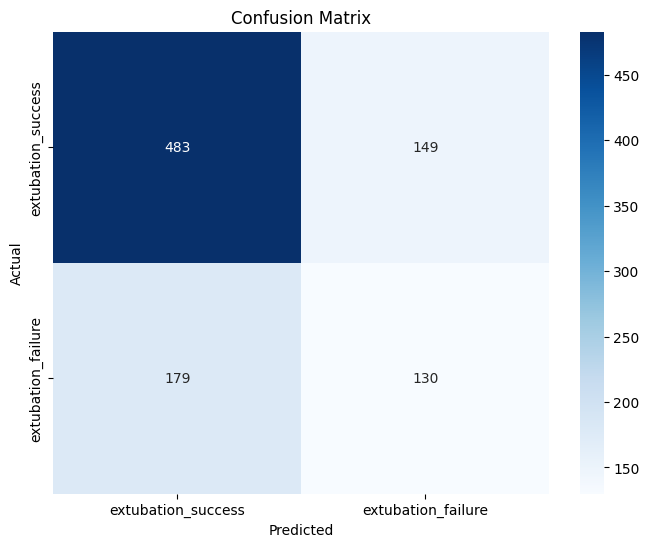

In [ ]:
y_true, y_pred, y_scores = get_model_predictions(final_model, test_loader, device)

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

The model predicts all failure classes - highlighting the sensitivity to feature engineering.

**Classification threshold**

We can see whether there is a better classification threshold than 0.5 which is the standard currently used.

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def find_best_threshold_and_evaluate(model, test_loader, device):
    """
    Find the best threshold for binary classification based on ROC AUC and calculate evaluation metrics.

    Parameters:
    model (nn.Module): The trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    dict: A dictionary containing the best threshold, ROC AUC, and other evaluation metrics.
    """
    model.eval()  # Set the model to evaluation mode

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            # Get model output (predicted probabilities)
            output = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)

            # Append predicted probabilities and true labels
            all_probs.extend(output.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    best_threshold = 0.5
    best_metric_value = 0.0

    thresholds = np.arange(0.0, 1.0, 0.01)  # You can change the step size if needed

    for threshold in thresholds:
        preds = (all_probs >= threshold).astype(int)
        metric_value = roc_auc_score(all_labels, preds)

        if metric_value > best_metric_value:
            best_metric_value = metric_value
            best_threshold = threshold

    # Apply the best threshold to get the final predictions
    final_preds = (all_probs >= best_threshold).astype(int)

    # Calculate the final evaluation metrics
    accuracy = accuracy_score(all_labels, final_preds)
    precision = precision_score(all_labels, final_preds)
    recall = recall_score(all_labels, final_preds)
    f1 = f1_score(all_labels, final_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for ROC AUC
    specificity = recall_score(all_labels, final_preds, pos_label=0)

    metrics = {
        'best_threshold': best_threshold,
        'best_metric_value': best_metric_value,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'specificity': specificity
    }

    print(f"Best Threshold: {best_threshold}")
    print(f"Best Metric Value: {best_metric_value}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return metrics

In [ ]:
find_best_threshold_and_evaluate(final_model, test_loader, device)

Best Threshold: 0.51
Best Metric Value: 0.5971155421736103
Accuracy: 0.6610
Precision: 0.4811
Recall: 0.4110
F1 Score: 0.4433
ROC AUC: 0.6302
Specificity: 0.7832


{'best_threshold': 0.51,
 'best_metric_value': 0.5971155421736103,
 'accuracy': 0.6609989373007439,
 'precision': 0.4810606060606061,
 'recall': 0.4110032362459547,
 'f1_score': 0.4432809773123909,
 'roc_auc': 0.6302332964647085,
 'specificity': 0.7832278481012658}

**Plot ROC curve**

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import roc_curve

def plot_roc_curve(model, test_loader, device):
    """
    Generates and plots the ROC curve for the given model and test data.

    Parameters:
    model (torch.nn.Module): The trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): The device to run the model on (CPU or GPU).

    Returns:
    None
    """
    model.to(device)
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            # Get model output (predicted probabilities)
            output = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)

            # Append predicted probabilities and true labels
            all_probs.extend(output.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc_score(all_labels, all_probs)))
    plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


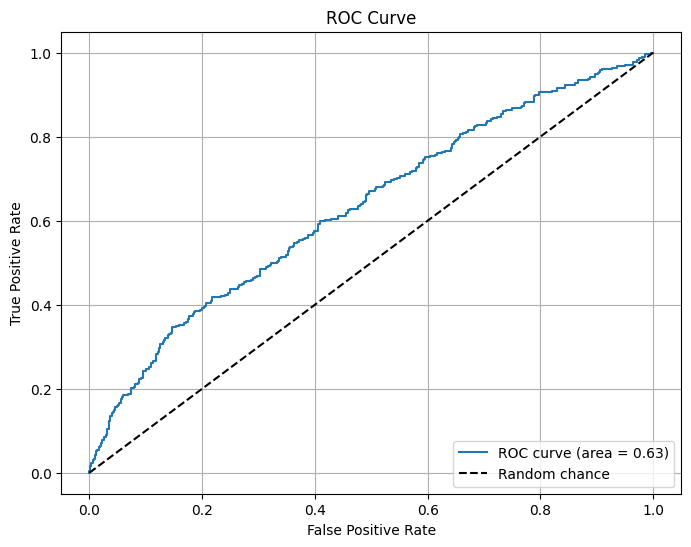

In [ ]:
plot_roc_curve(final_model, test_loader, device)

The curve is better than the straight line shown for the simpler architecture.

### **Model Interpretability**

We can now implement feature ablation.

In [ ]:
# Load the feature names
low_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/low_freq_feature_names_v1.npy'
medium_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/medium_freq_feature_names_v1.npy'
high_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/high_freq_feature_names_v1.npy'

low_freq_feature_names = np.load(low_feature_names, allow_pickle=True)
medium_freq_feature_names = np.load(medium_feature_names, allow_pickle=True)
high_freq_feature_names = np.load(high_feature_names, allow_pickle=True)

print(low_freq_feature_names)
print(medium_freq_feature_names)
print(high_freq_feature_names)

['PH (Arterial)' 'Arterial O2 pressure' 'Arterial CO2 Pressure'
 'Arterial Base Excess' 'Sodium (serum)' 'Potassium (serum)'
 'Glucose (serum)' 'Creatinine (serum)' 'Hematocrit (serum)'
 'Cardiac Output (CCO)' 'Ionized Calcium' 'Hemoglobin' 'Platelet Count'
 'WBC' 'Arterial O2 Saturation' 'Lactic Acid' 'EtCO2' 'Plateau Pressure']
['Inspired O2 Fraction' 'GCS - Eye Opening' 'GCS - Motor Response'
 'Tidal Volume (observed)' 'Minute Volume' 'Mean Airway Pressure'
 'Peak Insp. Pressure' 'Temperature Fahrenheit'
 'Tidal Volume (spontaneous)' 'Richmond-RAS Scale']
['Heart Rate' 'O2 saturation pulseoxymetry' 'Respiratory Rate'
 'Arterial Blood Pressure mean' 'Arterial Blood Pressure diastolic'
 'Arterial Blood Pressure systolic']


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model_ablation(model, data_loader, criterion, device):
    model.eval()
    all_labels = []
    all_outputs = []
    total_loss = 0.0

    with torch.no_grad():
        for data in data_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)

            all_outputs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    precision = precision_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    recall = recall_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    f1 = f1_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    roc_auc = roc_auc_score(all_labels, all_outputs)
    specificity = recall_score(all_labels, (np.array(all_outputs) <= 0.5).astype(int))

    return avg_loss, accuracy, precision, recall, f1, roc_auc, specificity

In [ ]:
def feature_ablation_with_names(low_train_sequences, medium_train_sequences, high_train_sequences, train_labels,
                                low_test_sequences, medium_test_sequences, high_test_sequences, test_labels,
                                model, best_hyperparams, device, low_feature_names, medium_feature_names, high_feature_names):
    """
    Perform feature ablation by retraining the model without each feature.

    Parameters:
    low_train_sequences (np.array): The low frequency training sequences.
    medium_train_sequences (np.array): The medium frequency training sequences.
    high_train_sequences (np.array): The high frequency training sequences.
    train_labels (np.array): The training labels.
    low_test_sequences (np.array): The low frequency test sequences.
    medium_test_sequences (np.array): The medium frequency test sequences.
    high_test_sequences (np.array): The high frequency test sequences.
    test_labels (np.array): The test labels.
    model (nn.Module): The trained fused LSTM model.
    best_hyperparams (dict): The best hyperparameters.
    device (torch.device): The device to run the model on.
    low_feature_names (list): List of low frequency feature names.
    medium_feature_names (list): List of medium frequency feature names.
    high_feature_names (list): List of high frequency feature names.

    Returns:
    feature_importances (pd.DataFrame): DataFrame containing the importance of each feature.
    """
    feature_importances = {}

    criterion = nn.BCELoss()
    test_loader = create_multi_input_data_loaders(
        low_test_sequences, medium_test_sequences, high_test_sequences, test_labels,
        low_test_sequences, medium_test_sequences, high_test_sequences, test_labels,
        low_test_sequences, medium_test_sequences, high_test_sequences, test_labels,
        best_hyperparams['batch_size']
    )[2]  # Only get the test loader

    _, base_accuracy, base_precision, base_recall, base_f1, base_roc_auc, base_specificity = evaluate_model_ablation(
        model, test_loader, criterion, device
    )

    def ablate_and_evaluate(train_sequences, test_sequences, feature_names, subset):
        for feature_idx in range(train_sequences.shape[2]):
            feature_name = feature_names[feature_idx]
            print(f"Ablating feature {feature_name} ({feature_idx + 1}/{train_sequences.shape[2]})")

            # Remove the feature from the sequences
            train_sequences_ablation = np.delete(train_sequences, feature_idx, axis=2)
            test_sequences_ablation = np.delete(test_sequences, feature_idx, axis=2)

            if subset == 0:
                train_loader, val_loader, test_loader = create_multi_input_data_loaders(
                    train_sequences_ablation, medium_train_sequences, high_train_sequences, train_labels,
                    train_sequences_ablation, medium_train_sequences, high_train_sequences, train_labels,
                    test_sequences_ablation, medium_test_sequences, high_test_sequences, test_labels,
                    best_hyperparams['batch_size']
                )
            elif subset == 1:
                train_loader, val_loader, test_loader = create_multi_input_data_loaders(
                    low_train_sequences, train_sequences_ablation, high_train_sequences, train_labels,
                    low_train_sequences, train_sequences_ablation, high_train_sequences, train_labels,
                    low_test_sequences, test_sequences_ablation, high_test_sequences, test_labels,
                    best_hyperparams['batch_size']
                )
            else:
                train_loader, val_loader, test_loader = create_multi_input_data_loaders(
                    low_train_sequences, medium_train_sequences, train_sequences_ablation, train_labels,
                    low_train_sequences, medium_train_sequences, train_sequences_ablation, train_labels,
                    low_test_sequences, medium_test_sequences, test_sequences_ablation, test_labels,
                    best_hyperparams['batch_size']
                )

            # Initialize a new model for this ablation
            ablation_model = FusedLSTMModel(
                low_input_dim=low_train_sequences.shape[2] - (1 if subset == 0 else 0),
                medium_input_dim=medium_train_sequences.shape[2] - (1 if subset == 1 else 0),
                high_input_dim=high_train_sequences.shape[2] - (1 if subset == 2 else 0),
                hidden_dim=best_hyperparams['hidden_dim'],
                layer_dim=best_hyperparams['layer_dim'],
                output_dim=1,
                dropout_prob=best_hyperparams['dropout_prob']
            ).to(device)

            optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'])

            # Train the model
            ablation_model, _, _, _ = train_fused_model_with_early_stopping_logging(
                ablation_model, train_loader, val_loader, criterion, optimizer,
                best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
            )

            # Evaluate the model
            _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)

            feature_importances[feature_name] = {
                'accuracy': base_accuracy - accuracy,
                'precision': base_precision - precision,
                'recall': base_recall - recall,
                'f1': base_f1 - f1,
                'roc_auc': base_roc_auc - roc_auc,
                'specificity': base_specificity - specificity
            }

    ablate_and_evaluate(low_train_sequences, low_test_sequences, low_feature_names, 0)
    ablate_and_evaluate(medium_train_sequences, medium_test_sequences, medium_feature_names, 1)
    ablate_and_evaluate(high_train_sequences, high_test_sequences, high_feature_names, 2)

    # Convert feature importances to a DataFrame for better readability
    feature_importances_df = pd.DataFrame.from_dict(feature_importances, orient='index')
    feature_importances_df = feature_importances_df.sort_values(by='roc_auc', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importances_df.index, feature_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    return feature_importances_df

Ablating feature PH (Arterial) (1/18)
Epoch 0/49, Loss: 0.6933, Val Loss: 0.6930, Val AUC: 0.5481
Epoch 1/49, Loss: 0.6930, Val Loss: 0.6929, Val AUC: 0.5772
Epoch 2/49, Loss: 0.6927, Val Loss: 0.6928, Val AUC: 0.5958
Epoch 3/49, Loss: 0.6930, Val Loss: 0.6926, Val AUC: 0.6032
Epoch 4/49, Loss: 0.6926, Val Loss: 0.6924, Val AUC: 0.6062
Epoch 5/49, Loss: 0.6926, Val Loss: 0.6920, Val AUC: 0.6073
Epoch 6/49, Loss: 0.6917, Val Loss: 0.6910, Val AUC: 0.6052
Epoch 7/49, Loss: 0.6905, Val Loss: 0.6891, Val AUC: 0.6059
Epoch 8/49, Loss: 0.6883, Val Loss: 0.6861, Val AUC: 0.6063
Epoch 9/49, Loss: 0.6852, Val Loss: 0.6821, Val AUC: 0.6062
Epoch 10/49, Loss: 0.6832, Val Loss: 0.6791, Val AUC: 0.6079
Epoch 11/49, Loss: 0.6786, Val Loss: 0.6773, Val AUC: 0.6085
Epoch 12/49, Loss: 0.6780, Val Loss: 0.6752, Val AUC: 0.6104
Epoch 13/49, Loss: 0.6772, Val Loss: 0.6745, Val AUC: 0.6116
Epoch 14/49, Loss: 0.6768, Val Loss: 0.6750, Val AUC: 0.6128
Epoch 15/49, Loss: 0.6763, Val Loss: 0.6741, Val AUC: 0.6

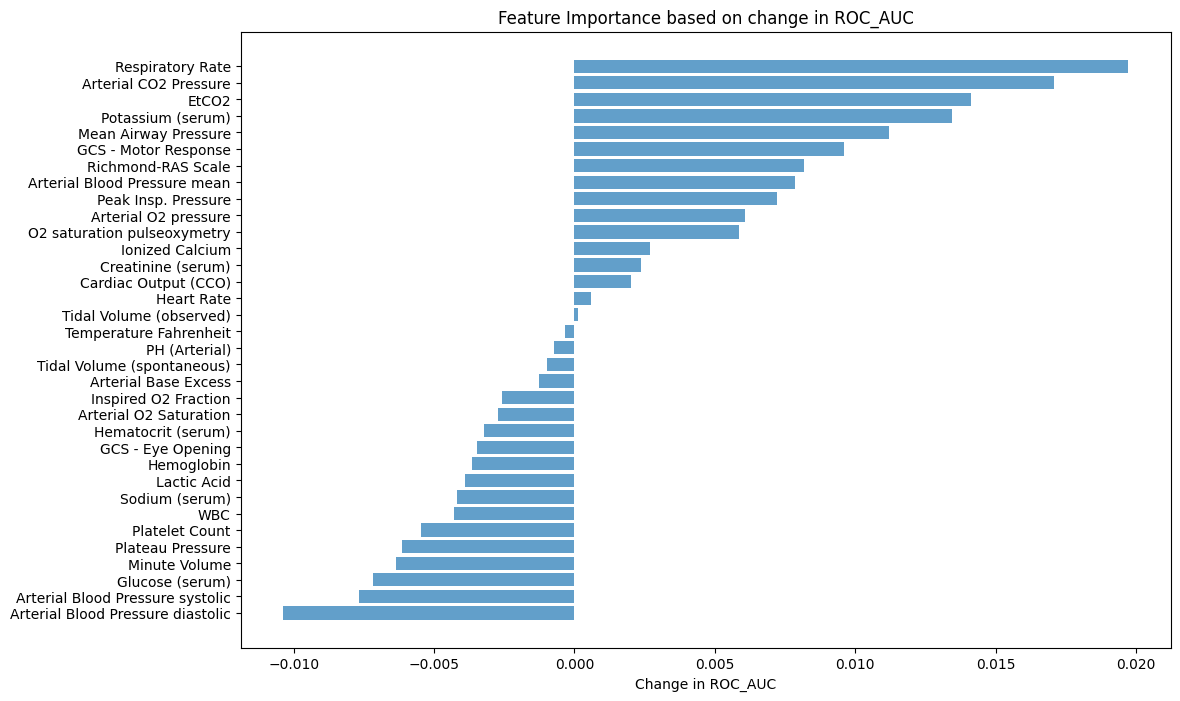

In [ ]:
# Execute feature ablation
feature_importances_df = feature_ablation_with_names(
    train_low_sequences_resampled,
    train_medium_sequences_resampled,
    train_high_sequences_resampled,
    train_labels_resampled,
    low_freq_test_sequences,
    medium_freq_test_sequences,
    high_freq_test_sequences,
    labels_test,
    final_model,
    best_params,
    device,
    low_freq_feature_names,
    medium_freq_feature_names,
    high_freq_feature_names
)

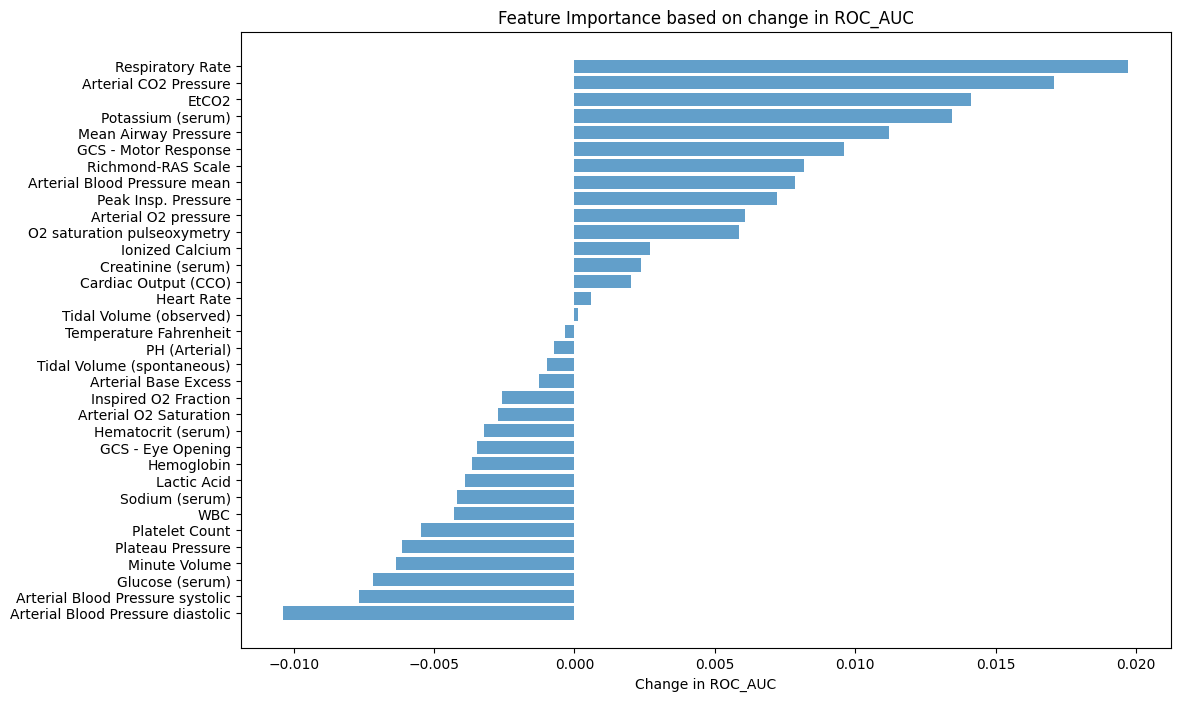